<a href="https://colab.research.google.com/github/onurercen/workout_prediction_app/blob/main/DT_Experience_Level.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Decision Tree - Experience Level Prediction

**Proje:** Spor Salonu Üyelerinin Deneyim Seviyesi Tahmini  
**Model:** Decision Tree Classifier  
**Standart Ayarlar:** test_size=0.30, random_state=42, cv=5

---



## 1) Problem Definition & Setup

**Objective:** Spor salonu üyelerinin fizyolojik ve egzersiz verilerini kullanarak deneyim seviyelerini (Beginner, Intermediate, Advanced) tahmin etmek.

**Task Type:** Multi-class Classification (3 sınıf)

**Evaluation Metrics:** Accuracy, Precision, Recall, F1-Score

In [101]:
# ============================================================================
# IMPORTS
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Sklearn - Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE

# Sklearn - Model
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

# Sklearn - Metrics
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                            precision_recall_fscore_support, roc_auc_score, f1_score)

# Model Persistence
import joblib
import pickle

import warnings
warnings.filterwarnings('ignore')

print('Kütüphaneler yüklendi.')
print(f'Pandas: {pd.__version__}')
print(f'NumPy: {np.__version__}')

Kütüphaneler yüklendi.
Pandas: 2.2.2
NumPy: 2.0.2


## 2) Data Collection & Exploration (EDA)

In [102]:
# ============================================================================
# 2.1 DATA LOADING
# ============================================================================
df = pd.read_csv('gym_members_exercise_tracking.csv')

print('='*70)
print('DECISION TREE - EXPERIENCE LEVEL PREDICTION')
print('='*70)
print(f'\nVeri Seti Boyutu: {df.shape[0]} satır, {df.shape[1]} sütun')
print(f'\nSütunlar:\n{list(df.columns)}')
print(f'\nVeri Tipleri:')
print(df.dtypes)

DECISION TREE - EXPERIENCE LEVEL PREDICTION

Veri Seti Boyutu: 973 satır, 15 sütun

Sütunlar:
['Age', 'Gender', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)', 'Calories_Burned', 'Workout_Type', 'Fat_Percentage', 'Water_Intake (liters)', 'Workout_Frequency (days/week)', 'Experience_Level', 'BMI']

Veri Tipleri:
Age                                int64
Gender                            object
Weight (kg)                      float64
Height (m)                       float64
Max_BPM                            int64
Avg_BPM                            int64
Resting_BPM                        int64
Session_Duration (hours)         float64
Calories_Burned                  float64
Workout_Type                      object
Fat_Percentage                   float64
Water_Intake (liters)            float64
Workout_Frequency (days/week)      int64
Experience_Level                   int64
BMI                              float64
dtype: object


In [103]:
# ============================================================================
# 2.2 MISSING VALUE ANALYSIS
# ============================================================================
print('='*70)
print('MISSING VALUE ANALİZİ')
print('='*70)

missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
})

print(missing_df[missing_df['Missing Count'] > 0] if missing.sum() > 0 else 'Eksik değer YOK')
print(f'\nToplam eksik değer: {missing.sum()}')

MISSING VALUE ANALİZİ
Eksik değer YOK

Toplam eksik değer: 0


TARGET DEĞİŞKEN ANALİZİ

Experience Level Dağılımı:
  Level 1 (Beginner): 376 (38.6%)
  Level 2 (Intermediate): 406 (41.7%)
  Level 3 (Advanced): 191 (19.6%)


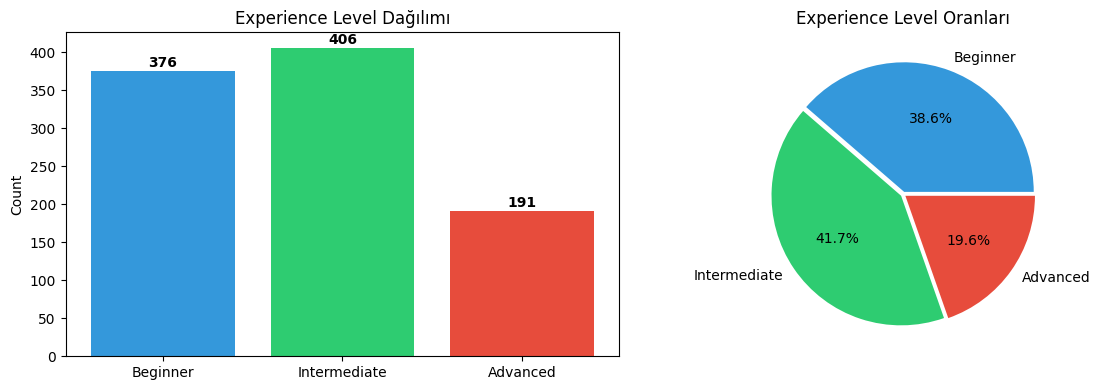


⚖️ Sınıf Dengesi Kontrolü:
  Max/Min Ratio: 2.13
Hafif sınıf dengesizliği var


In [104]:
# ============================================================================
# 2.3 TARGET VARIABLE ANALYSIS
# ============================================================================
print('='*70)
print('TARGET DEĞİŞKEN ANALİZİ')
print('='*70)

target_dist = df['Experience_Level'].value_counts().sort_index()
target_pct = df['Experience_Level'].value_counts(normalize=True).sort_index() * 100

print('\nExperience Level Dağılımı:')
for level, count in target_dist.items():
    pct = target_pct[level]
    label = {1: 'Beginner', 2: 'Intermediate', 3: 'Advanced'}[level]
    print(f'  Level {level} ({label}): {count} ({pct:.1f}%)')

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar plot
colors = ['#3498db', '#2ecc71', '#e74c3c']
axes[0].bar(['Beginner', 'Intermediate', 'Advanced'], target_dist.values, color=colors)
axes[0].set_title('Experience Level Dağılımı')
axes[0].set_ylabel('Count')
for i, v in enumerate(target_dist.values):
    axes[0].text(i, v + 5, str(v), ha='center', fontweight='bold')

# Pie chart
axes[1].pie(target_dist.values, labels=['Beginner', 'Intermediate', 'Advanced'],
            autopct='%1.1f%%', colors=colors, explode=[0.02, 0.02, 0.02])
axes[1].set_title('Experience Level Oranları')

plt.tight_layout()
plt.savefig('target_distribution.png', dpi=150)
plt.show()

# Class balance check
print(f'\n⚖️ Sınıf Dengesi Kontrolü:')
imbalance_ratio = target_dist.max() / target_dist.min()
print(f'  Max/Min Ratio: {imbalance_ratio:.2f}')
if imbalance_ratio > 3:
    print('Ciddi sınıf dengesizliği var!')
elif imbalance_ratio > 1.5:
    print('Hafif sınıf dengesizliği var')
else:
    print('Sınıflar dengeli')

SAYISAL DEĞİŞKEN DAĞILIMLARI
Sayısal değişkenler: ['Age', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)', 'Calories_Burned', 'Fat_Percentage', 'Water_Intake (liters)', 'Workout_Frequency (days/week)', 'BMI']

İstatistiksel Özet:
          Age  Weight (kg)  Height (m)  Max_BPM  Avg_BPM  Resting_BPM  \
count  973.00       973.00      973.00   973.00   973.00       973.00   
mean    38.68        73.85        1.72   179.88   143.77        62.22   
std     12.18        21.21        0.13    11.53    14.35         7.33   
min     18.00        40.00        1.50   160.00   120.00        50.00   
25%     28.00        58.10        1.62   170.00   131.00        56.00   
50%     40.00        70.00        1.71   180.00   143.00        62.00   
75%     49.00        86.00        1.80   190.00   156.00        68.00   
max     59.00       129.90        2.00   199.00   169.00        74.00   

       Session_Duration (hours)  Calories_Burned  Fat_Percentage  \

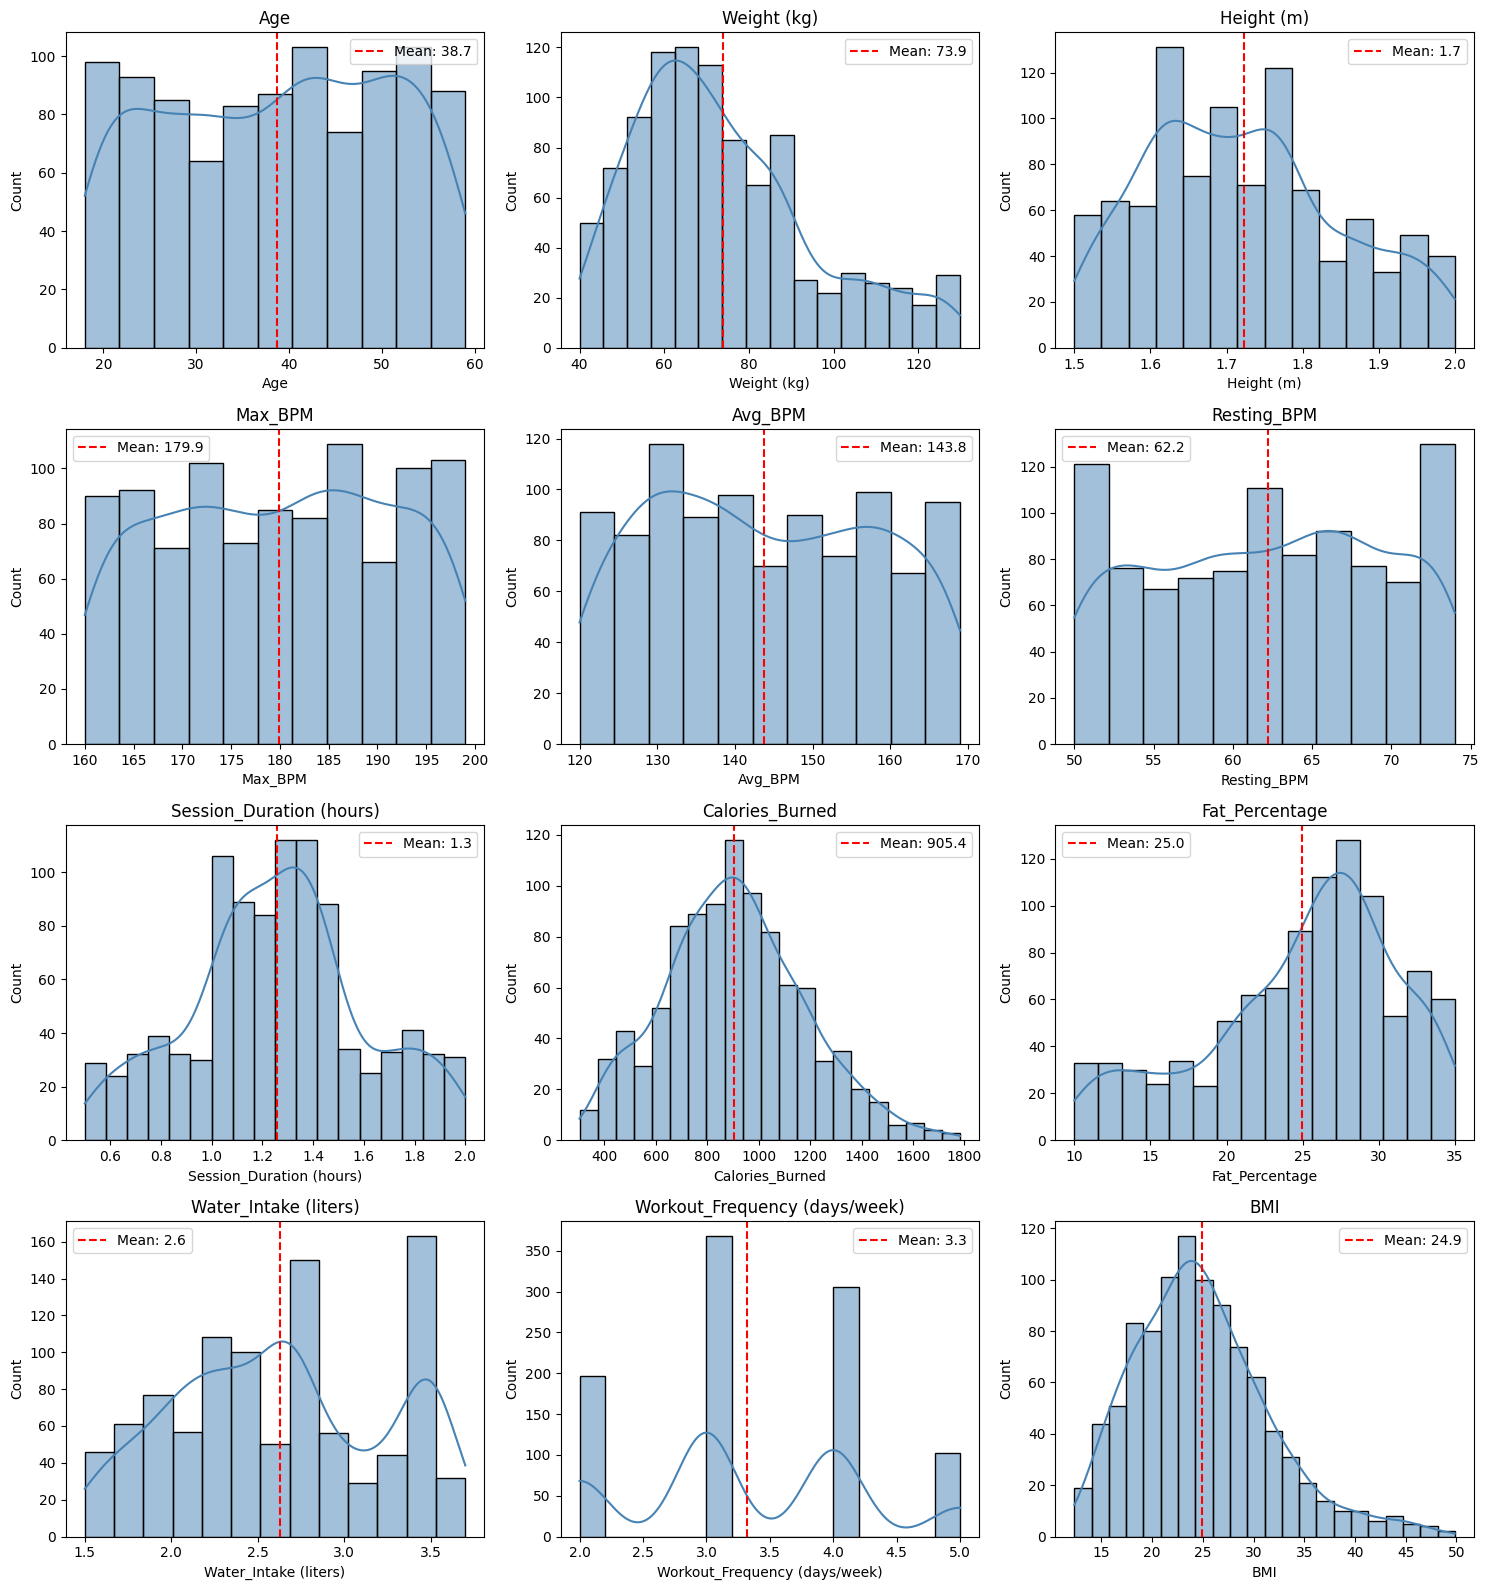

In [ ]:
# ============================================================================
# 2.4 NUMERICAL FEATURES DISTRIBUTION
# ============================================================================
print('='*70)
print('SAYISAL DEĞİŞKEN DAĞILIMLARI')
print('='*70)

numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols.remove('Experience_Level')  # Target'ı çıkar

print(f'Sayısal değişkenler: {numerical_cols}')
print(f'\nİstatistiksel Özet:')
print(df[numerical_cols].describe().round(2))

# Distribution plots
n_cols = 3
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], color='steelblue')
    axes[i].set_title(f'{col}')
    axes[i].axvline(df[col].mean(), color='red', linestyle='--', label=f'Mean: {df[col].mean():.1f}')
    axes[i].legend()

# Hide empty subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=150)
plt.show()

OUTLIER ANALİZİ (IQR Method)
                      Feature  Outliers  Outlier %  Lower Bound  Upper Bound
                          Age         0   0.000000       -3.500       80.500
                  Weight (kg)         9   0.924974       16.250      127.850
                   Height (m)         0   0.000000        1.350        2.070
                      Max_BPM         0   0.000000      140.000      220.000
                      Avg_BPM         0   0.000000       93.500      193.500
                  Resting_BPM         0   0.000000       38.000       86.000
     Session_Duration (hours)         0   0.000000        0.410        2.090
              Calories_Burned        10   1.027749      186.000     1610.000
               Fat_Percentage         0   0.000000        9.300       41.300
        Water_Intake (liters)         0   0.000000        0.850        4.450
Workout_Frequency (days/week)         0   0.000000        1.500        5.500
                          BMI        25   2.569

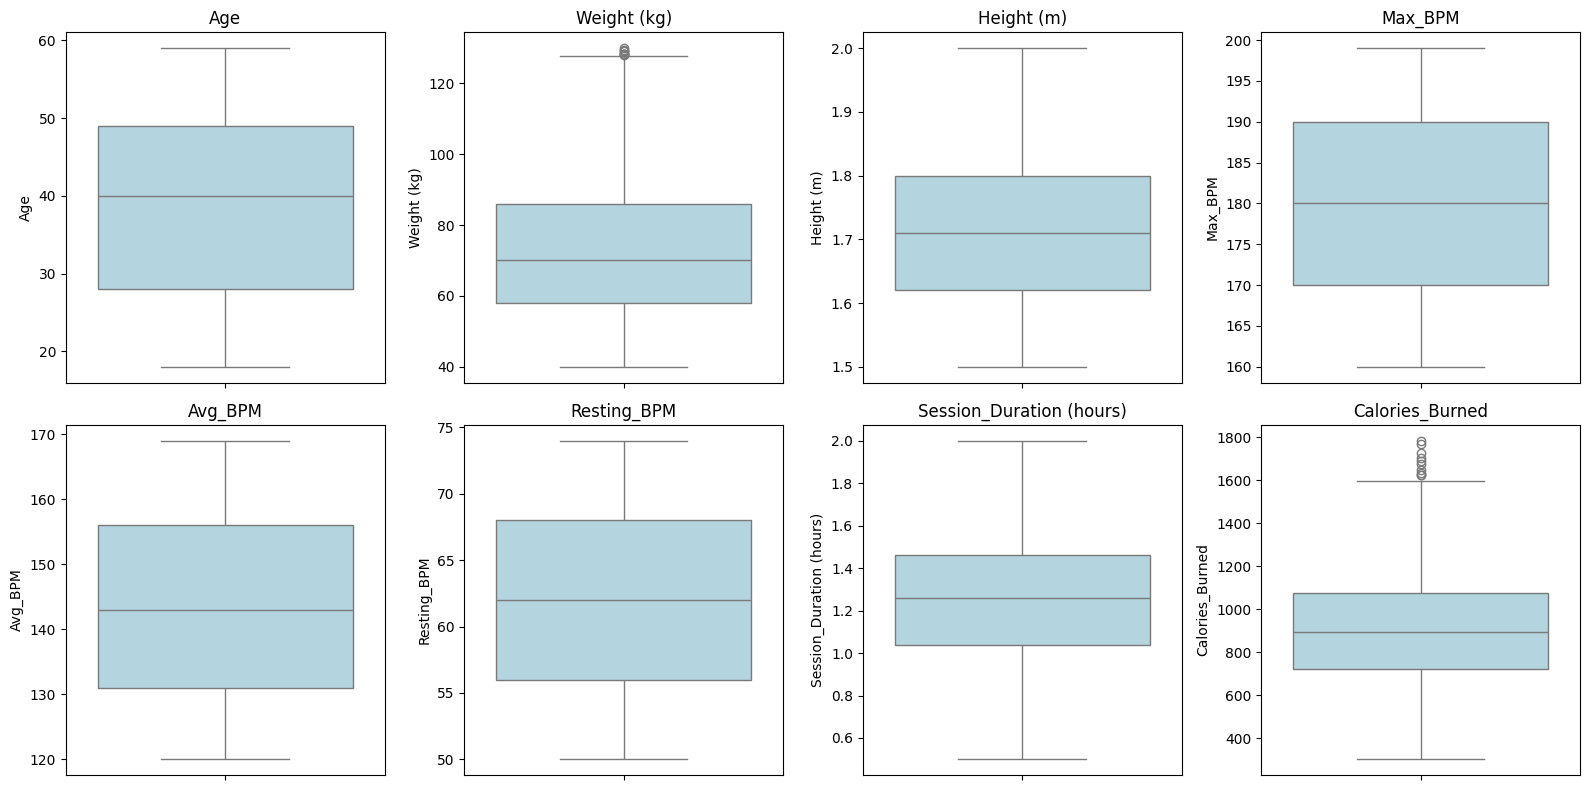


Outlier Handling Kararı:
  Decision Tree outlier'lara dayanıklıdır (non-parametric).
  Bu nedenle outlier'lar KALDIRILMAYACAK.


In [ ]:
# ============================================================================
# 2.5 OUTLIER DETECTION (IQR Method)
# ============================================================================
print('='*70)
print('OUTLIER ANALİZİ (IQR Method)')
print('='*70)

def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return len(outliers), lower_bound, upper_bound

outlier_summary = []
for col in numerical_cols:
    n_outliers, lb, ub = detect_outliers_iqr(df, col)
    outlier_pct = (n_outliers / len(df)) * 100
    outlier_summary.append({
        'Feature': col,
        'Outliers': n_outliers,
        'Outlier %': outlier_pct,
        'Lower Bound': lb,
        'Upper Bound': ub
    })

outlier_df = pd.DataFrame(outlier_summary)
print(outlier_df.to_string(index=False))

# Boxplot for outlier visualization
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(numerical_cols[:8]):  # İlk 8 feature
    sns.boxplot(data=df, y=col, ax=axes[i], color='lightblue')
    axes[i].set_title(f'{col}')

plt.tight_layout()
plt.savefig('outlier_boxplots.png', dpi=150)
plt.show()

print('\nOutlier Handling Kararı:')
print("  Decision Tree outlier'lara dayanıklıdır (non-parametric).")
print("  Bu nedenle outlier'lar KALDIRILMAYACAK.")

KORELASYON ANALİZİ

Experience Level ile Korelasyonlar:
Workout_Frequency (days/week)    0.837
Session_Duration (hours)         0.765
Calories_Burned                  0.694
Water_Intake (liters)            0.304
BMI                              0.016
Weight (kg)                      0.003
Resting_BPM                      0.002
Max_BPM                          0.001
Avg_BPM                         -0.001
Height (m)                      -0.010
Age                             -0.019
Fat_Percentage                  -0.654
Name: Experience_Level, dtype: float64


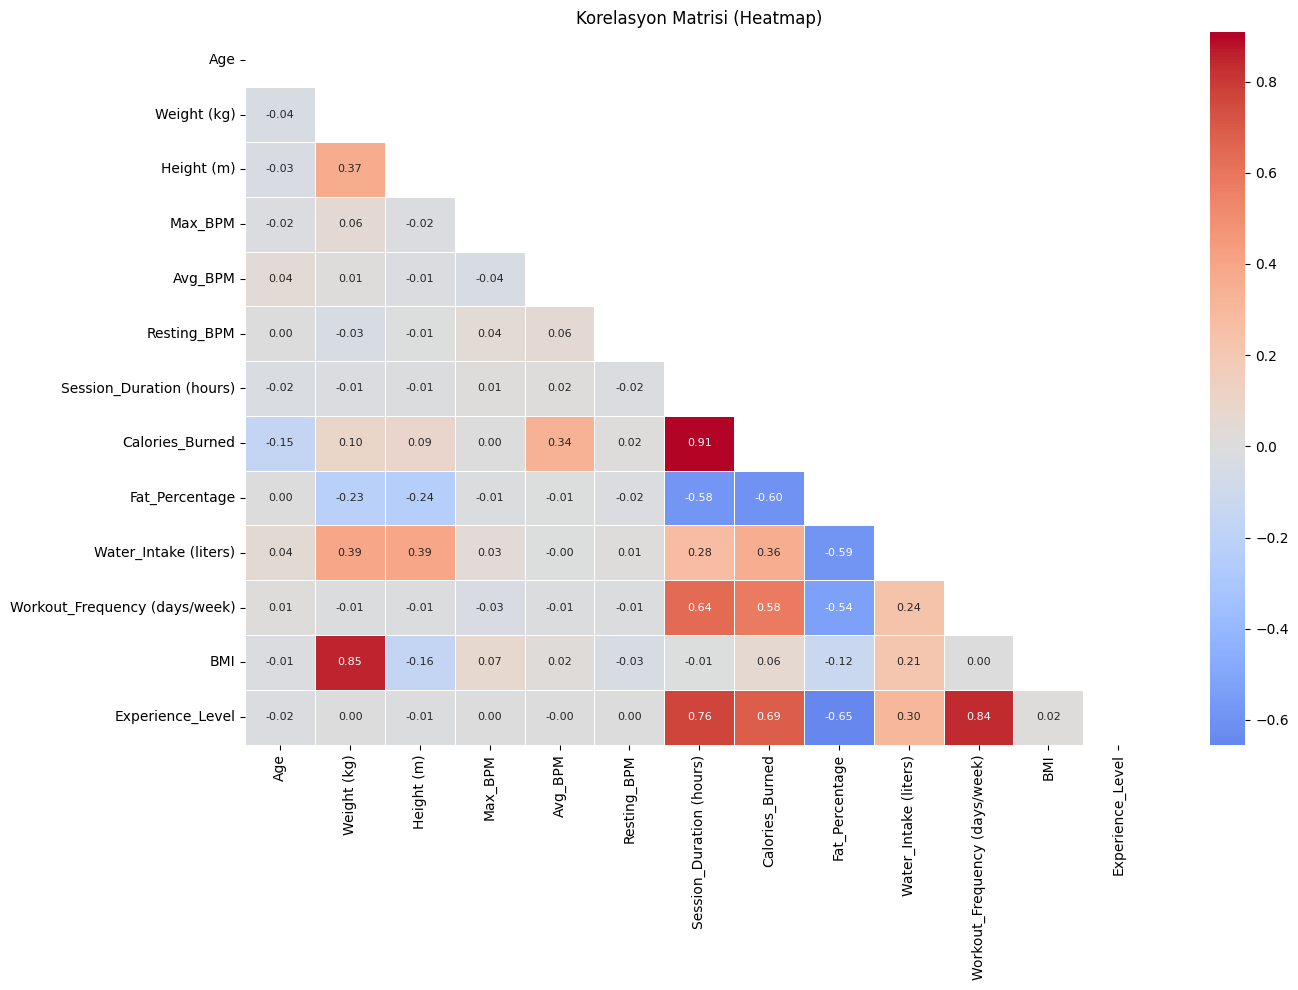


 Yüksek Korelasyonlu Feature Çiftleri (|r| > 0.7):
  Weight (kg) <-> BMI: 0.853
  Session_Duration (hours) <-> Calories_Burned: 0.908
  Session_Duration (hours) <-> Experience_Level: 0.765
  Workout_Frequency (days/week) <-> Experience_Level: 0.837


In [ ]:
# ============================================================================
# 2.6 CORRELATION ANALYSIS
# ============================================================================
print('='*70)
print('KORELASYON ANALİZİ')
print('='*70)

# Correlation matrix
corr_matrix = df[numerical_cols + ['Experience_Level']].corr()

# Target ile korelasyonlar
target_corr = corr_matrix['Experience_Level'].drop('Experience_Level').sort_values(ascending=False)
print('\nExperience Level ile Korelasyonlar:')
print(target_corr.round(3))

# Heatmap
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, linewidths=0.5, annot_kws={'size': 8})
plt.title('Korelasyon Matrisi (Heatmap)')
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=150)
plt.show()

# Highly correlated features
print('\n Yüksek Korelasyonlu Feature Çiftleri (|r| > 0.7):')
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

for pair in high_corr_pairs:
    print(f'  {pair[0]} <-> {pair[1]}: {pair[2]:.3f}')

## 3) Data Preprocessing

In [ ]:
# ============================================================================
# 3.1 FEATURE ENGINEERING
# ============================================================================
print('='*70)
print('FEATURE ENGINEERING')
print('='*70)

# Temel fizyolojik feature'lar
df['HR_per_minute'] = df['Avg_BPM'] / (df['Session_Duration (hours)'] * 60)
df['Intensity_per_Weight'] = df['Calories_Burned'] / df['Weight (kg)']
df['HRR'] = df['Max_BPM'] - df['Resting_BPM']  # Heart Rate Reserve
df['Efficiency'] = df['Calories_Burned'] / df['Avg_BPM']
df['Anaerobic_Index'] = (df['Max_BPM'] - df['Avg_BPM']) / df['Resting_BPM']
df['BPM_Variance_Rest'] = (df['Avg_BPM'] - df['Resting_BPM']) ** 2
df['Heart_Instability'] = abs(df['Max_BPM'] - df['Avg_BPM']) / df['Max_BPM']

# Ek feature'lar
df['Calories_per_Hour'] = df['Calories_Burned'] / df['Session_Duration (hours)']
df['Heart_Efficiency'] = df['Calories_Burned'] / df['HRR']
df['BMI_Category'] = pd.cut(df['BMI'], bins=[0, 18.5, 25, 30, 100], labels=[0, 1, 2, 3]).astype(int)
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 25, 35, 45, 100], labels=[0, 1, 2, 3]).astype(int)

# Deneyim seviyesi ile ilgili özel feature'lar
df['Workout_Intensity'] = df['Calories_Burned'] * df['Max_BPM'] / 1000
df['Performance_Score'] = df['Calories_Burned'] * df['Workout_Frequency (days/week)']
df['Fitness_Level'] = df['HRR'] / df['Resting_BPM']
df['Training_Load'] = df['Session_Duration (hours)'] * df['Workout_Frequency (days/week)'] * df['Avg_BPM']

print(' 15 yeni feature oluşturuldu:')
new_features = ['HR_per_minute', 'Intensity_per_Weight', 'HRR', 'Efficiency',
                'Anaerobic_Index', 'BPM_Variance_Rest', 'Heart_Instability',
                'Calories_per_Hour', 'Heart_Efficiency', 'BMI_Category', 'Age_Group',
                'Workout_Intensity', 'Performance_Score', 'Fitness_Level', 'Training_Load']
for f in new_features:
    print(f'   - {f}')

FEATURE ENGINEERING
 15 yeni feature oluşturuldu:
   - HR_per_minute
   - Intensity_per_Weight
   - HRR
   - Efficiency
   - Anaerobic_Index
   - BPM_Variance_Rest
   - Heart_Instability
   - Calories_per_Hour
   - Heart_Efficiency
   - BMI_Category
   - Age_Group
   - Workout_Intensity
   - Performance_Score
   - Fitness_Level
   - Training_Load


In [ ]:
# ============================================================================
# 3.2 CATEGORICAL ENCODING
# ============================================================================
print('='*70)
print('CATEGORICAL ENCODING')
print('='*70)

le_gender = LabelEncoder()
le_workout = LabelEncoder()

df['Gender_Encoded'] = le_gender.fit_transform(df['Gender'])
df['Workout_Type_Encoded'] = le_workout.fit_transform(df['Workout_Type'])

print(' Label Encoding tamamlandı:')
print(f"   Gender: {dict(zip(le_gender.classes_, range(len(le_gender.classes_))))}")
print(f"   Workout: {dict(zip(le_workout.classes_, range(len(le_workout.classes_))))}")

# NOT: Decision Tree için One-Hot Encoding gerekmez
print('\n NOT: Decision Tree kategorik değişkenleri doğrudan işleyebilir.')
print('   Label Encoding tercih edildi.')

CATEGORICAL ENCODING
 Label Encoding tamamlandı:
   Gender: {'Female': 0, 'Male': 1}
   Workout: {'Cardio': 0, 'HIIT': 1, 'Strength': 2, 'Yoga': 3}

 NOT: Decision Tree kategorik değişkenleri doğrudan işleyebilir.
   Label Encoding tercih edildi.


FEATURE SELECTION
 Feature sayısı: 29
 Sample sayısı: 973

 ANOVA F-Score ile Feature Sıralaması:
                      Feature     F-Score       P-Value
                Training_Load 1803.792040  0.000000e+00
            Performance_Score 1630.079228 6.328820e-311
Workout_Frequency (days/week) 1136.757683 5.515065e-255
               Fat_Percentage  892.970574 1.130760e-220
     Session_Duration (hours)  797.318555 1.609603e-205
                   Efficiency  688.931583 6.426754e-187
              Calories_Burned  503.470906 1.064771e-150
            Workout_Intensity  462.446746 9.029444e-142
             Heart_Efficiency  371.147678 1.988987e-120
                HR_per_minute  301.507680 1.475041e-102
         Intensity_per_Weight  175.298031  1.025279e-65
        Water_Intake (liters)   98.285079  1.356821e-39
         Workout_Type_Encoded    1.371233  2.542854e-01
                          BMI    0.950213  3.870182e-01
            Heart_Instability    0.908005  4.036707e-01


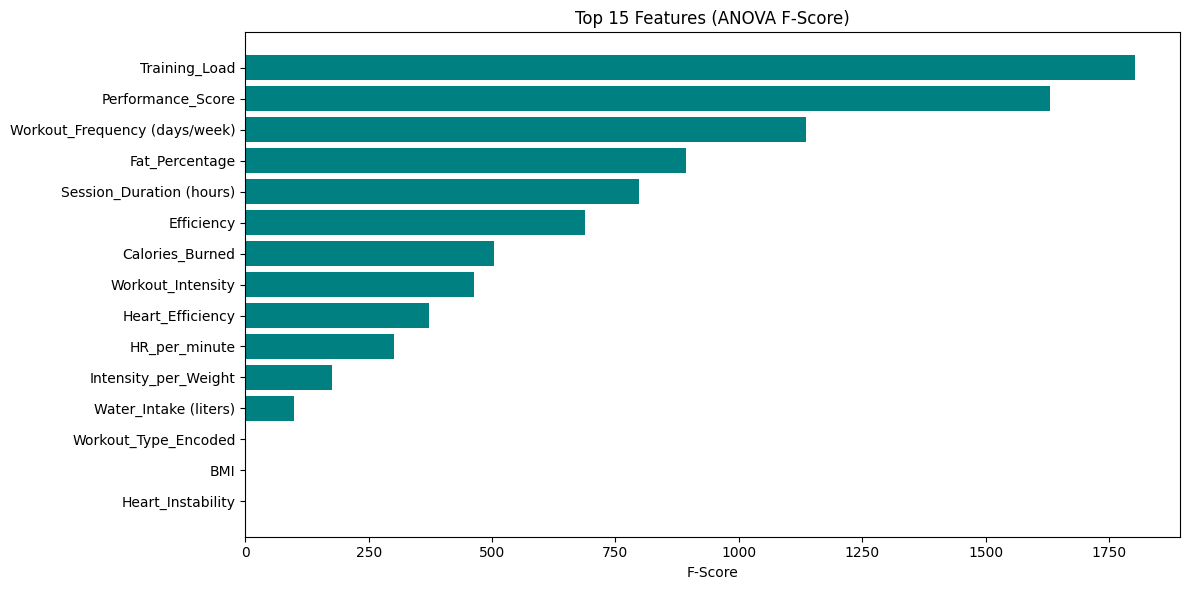

In [ ]:
# ============================================================================
# 3.3 FEATURE SELECTION
# ============================================================================
print('='*70)
print('FEATURE SELECTION')
print('='*70)

feature_cols = [
    'Age', 'Gender_Encoded', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM',
    'Session_Duration (hours)', 'Calories_Burned', 'Workout_Frequency (days/week)',
    'Fat_Percentage', 'Water_Intake (liters)', 'Workout_Type_Encoded', 'BMI',
    'HR_per_minute', 'Intensity_per_Weight', 'HRR', 'Efficiency',
    'Anaerobic_Index', 'BPM_Variance_Rest', 'Heart_Instability',
    'Calories_per_Hour', 'Heart_Efficiency', 'BMI_Category', 'Age_Group',
    'Workout_Intensity', 'Performance_Score', 'Fitness_Level', 'Training_Load'
]

X = df[feature_cols]
y = df['Experience_Level']

print(f' Feature sayısı: {X.shape[1]}')
print(f' Sample sayısı: {X.shape[0]}')

# SelectKBest ile en önemli feature'ları belirle
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X, y)

feature_scores = pd.DataFrame({
    'Feature': feature_cols,
    'F-Score': selector.scores_,
    'P-Value': selector.pvalues_
}).sort_values('F-Score', ascending=False)

print('\n ANOVA F-Score ile Feature Sıralaması:')
print(feature_scores.head(15).to_string(index=False))

# Visualization
plt.figure(figsize=(12, 6))
top_features = feature_scores.head(15)
plt.barh(range(len(top_features)), top_features['F-Score'], color='teal')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('F-Score')
plt.title('Top 15 Features (ANOVA F-Score)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_selection_anova.png', dpi=150)
plt.show()

In [ ]:
# ============================================================================
# 3.4 NORMALIZATION/STANDARDIZATION CHECK
# ============================================================================
print('='*70)
print('NORMALIZATION KONTROLÜ')
print('='*70)

print('''
Decision Tree için Normalization/Standardization GEREKLİ DEĞİLDİR.

Nedeni:
- Decision Tree sadece "eşik değerleri" (thresholds) kullanır
- Örn: "Age < 35 mi?" sorusu scale'dan etkilenmez
- Tree-based modeller (DT, RF, XGBoost) scale-invariant'tır

Bu nedenle StandardScaler UYGULANMAYACAKTIR.

NOT: SVM veya Neural Network kullanılsaydı scaler zorunlu olurdu!
''')

NORMALIZATION KONTROLÜ

Decision Tree için Normalization/Standardization GEREKLİ DEĞİLDİR.

Nedeni:
- Decision Tree sadece "eşik değerleri" (thresholds) kullanır
- Örn: "Age < 35 mi?" sorusu scale'dan etkilenmez
- Tree-based modeller (DT, RF, XGBoost) scale-invariant'tır

Bu nedenle StandardScaler UYGULANMAYACAKTIR.

NOT: SVM veya Neural Network kullanılsaydı scaler zorunlu olurdu!



## 4) Dataset Splitting

In [ ]:
# ============================================================================
# 4.1 TRAIN/TEST SPLIT
# ============================================================================
print('='*70)
print('TRAIN/TEST SPLIT')
print('='*70)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,       # %30 test
    random_state=42,      # Reproducibility
    stratify=y            # Sınıf dengesi korunur
)

print(f' Split tamamlandı:')
print(f'   Train set: {X_train.shape[0]} sample ({X_train.shape[0]/len(X)*100:.0f}%)')
print(f'   Test set:  {X_test.shape[0]} sample ({X_test.shape[0]/len(X)*100:.0f}%)')

# Stratification check
print(f'\n Stratification Kontrolü:')
print(f'   Original dağılım: {dict(y.value_counts().sort_index())}')
print(f'   Train dağılım:    {dict(y_train.value_counts().sort_index())}')
print(f'   Test dağılım:     {dict(y_test.value_counts().sort_index())}')

TRAIN/TEST SPLIT
 Split tamamlandı:
   Train set: 681 sample (70%)
   Test set:  292 sample (30%)

 Stratification Kontrolü:
   Original dağılım: {1: np.int64(376), 2: np.int64(406), 3: np.int64(191)}
   Train dağılım:    {1: np.int64(263), 2: np.int64(284), 3: np.int64(134)}
   Test dağılım:     {1: np.int64(113), 2: np.int64(122), 3: np.int64(57)}


In [ ]:
# ============================================================================
# 4.2 DATA LEAKAGE CHECK
# ============================================================================
print('='*70)
print('DATA LEAKAGE KONTROLÜ')
print('='*70)

print('''
 Data Leakage önleme kontrolleri:

1. Feature Engineering:
   - Experience_Level target olarak ÇIKARILDI
   - Experience_Adjusted_Calories gibi target içeren feature'lar KULLANILMADI

2. Encoding:
   - LabelEncoder TÜM veri üzerinde fit edildi (kabul edilebilir - sadece mapping)
   - Target encoding KULLANILMADI

3. Normalization:
   - Decision Tree için gerekli olmadığından UYGULANMADI
   - SVM kullanılsaydı: scaler.fit(X_train) → scaler.transform(X_test)

4. Feature Selection:
   - SelectKBest bilgi amaçlı kullanıldı
   - Model eğitiminde TÜM feature'lar dahil edildi

5. Cross-Validation:
   - SADECE X_train üzerinde yapılacak
   - Test seti HİÇBİR ZAMAN CV'ye dahil edilmeyecek

''')

DATA LEAKAGE KONTROLÜ

 Data Leakage önleme kontrolleri:

1. Feature Engineering:
   - Experience_Level target olarak ÇIKARILDI
   - Experience_Adjusted_Calories gibi target içeren feature'lar KULLANILMADI
   
2. Encoding:
   - LabelEncoder TÜM veri üzerinde fit edildi (kabul edilebilir - sadece mapping)
   - Target encoding KULLANILMADI
   
3. Normalization:
   - Decision Tree için gerekli olmadığından UYGULANMADI
   - SVM kullanılsaydı: scaler.fit(X_train) → scaler.transform(X_test)
   
4. Feature Selection:
   - SelectKBest bilgi amaçlı kullanıldı
   - Model eğitiminde TÜM feature'lar dahil edildi

5. Cross-Validation:
   - SADECE X_train üzerinde yapılacak
   - Test seti HİÇBİR ZAMAN CV'ye dahil edilmeyecek




## 5) Model Selection & Training

In [ ]:
# ============================================================================
# 5.1 BASELINE MODEL
# ============================================================================
print('='*70)
print('BASELINE MODEL (Default Parameters)')
print('='*70)

dt_baseline = DecisionTreeClassifier(random_state=42)
dt_baseline.fit(X_train, y_train)

y_pred_baseline = dt_baseline.predict(X_test)
train_acc_baseline = accuracy_score(y_train, dt_baseline.predict(X_train))
test_acc_baseline = accuracy_score(y_test, y_pred_baseline)

print(f'\n Baseline Sonuçları:')
print(f'   Train Accuracy: {train_acc_baseline:.4f} ({train_acc_baseline*100:.2f}%)')
print(f'   Test Accuracy:  {test_acc_baseline:.4f} ({test_acc_baseline*100:.2f}%)')
print(f'   Overfitting Gap: {train_acc_baseline - test_acc_baseline:.4f}')
print(f'\n Ağaç Yapısı:')
print(f'   Derinlik: {dt_baseline.get_depth()}')
print(f'   Yaprak Sayısı: {dt_baseline.get_n_leaves()}')

if train_acc_baseline - test_acc_baseline > 0.10:
    print('\n CİDDİ OVERFITTING TESPİT EDİLDİ!')
    print('   Regularization (max_depth, min_samples) gerekli.')
elif train_acc_baseline - test_acc_baseline > 0.05:
    print('\n Hafif overfitting var, optimizasyon önerilir.')
else:
    print('\n Overfitting yok.')

BASELINE MODEL (Default Parameters)

 Baseline Sonuçları:
   Train Accuracy: 1.0000 (100.00%)
   Test Accuracy:  0.8699 (86.99%)
   Overfitting Gap: 0.1301

 Ağaç Yapısı:
   Derinlik: 15
   Yaprak Sayısı: 46

 CİDDİ OVERFITTING TESPİT EDİLDİ!
   Regularization (max_depth, min_samples) gerekli.


In [ ]:
# ============================================================================
# 5.2 HYPERPARAMETER TUNING (GridSearchCV)
# ============================================================================
print('='*70)
print('HYPERPARAMETER TUNING (GridSearchCV)')
print('='*70)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4, 5, 6, 7, 8, 10],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

total_combinations = 2 * 7 * 4 * 5  # criterion * max_depth * split * leaf
print(f'Toplam parametre kombinasyonu: {total_combinations}')
print(f'Toplam fit sayısı (5-fold CV): {total_combinations * 5}')

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

print('\nGridSearchCV başlatılıyor...')
grid_search.fit(X_train, y_train)

print(f'\n Tamamlandı!')
print(f'\n En İyi Parametreler:')
for param, value in grid_search.best_params_.items():
    print(f'   {param}: {value}')
print(f'\n En İyi CV Skoru: {grid_search.best_score_:.4f}')

HYPERPARAMETER TUNING (GridSearchCV)
Toplam parametre kombinasyonu: 280
Toplam fit sayısı (5-fold CV): 1400

GridSearchCV başlatılıyor...
Fitting 5 folds for each of 280 candidates, totalling 1400 fits


HYPERPARAMETER ANALİZİ


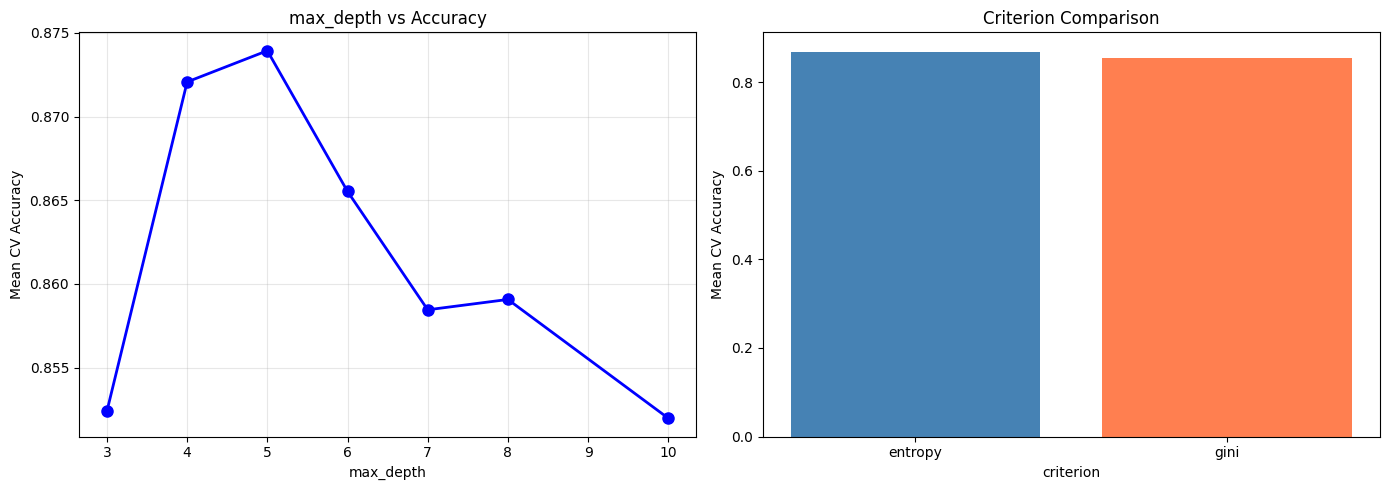


Top 10 Parametre Kombinasyonu:
                                                                                  params  mean_test_score  std_test_score  rank_test_score
 {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}         0.885423        0.024128                1
 {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5}         0.885423        0.024128                1
{'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 10}         0.883963        0.039094                3
 {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}         0.883952        0.026198                4
 {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}         0.883952        0.026198                4
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}         0.883952        0.026198             

In [86]:
# ============================================================================
# 5.3 HYPERPARAMETER ANALYSIS
# ============================================================================
print('='*70)
print('HYPERPARAMETER ANALİZİ')
print('='*70)

# CV sonuçlarını DataFrame'e çevir
cv_results = pd.DataFrame(grid_search.cv_results_)

# max_depth vs accuracy
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# max_depth etkisi
depth_scores = cv_results.groupby('param_max_depth')['mean_test_score'].mean()
axes[0].plot(depth_scores.index, depth_scores.values, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('max_depth')
axes[0].set_ylabel('Mean CV Accuracy')
axes[0].set_title('max_depth vs Accuracy')
axes[0].grid(True, alpha=0.3)

# criterion etkisi
criterion_scores = cv_results.groupby('param_criterion')['mean_test_score'].mean()
axes[1].bar(criterion_scores.index, criterion_scores.values, color=['steelblue', 'coral'])
axes[1].set_xlabel('criterion')
axes[1].set_ylabel('Mean CV Accuracy')
axes[1].set_title('Criterion Comparison')

plt.tight_layout()
plt.savefig('hyperparameter_analysis.png', dpi=150)
plt.show()

# Top 10 configurations
print('\nTop 10 Parametre Kombinasyonu:')
top_10 = cv_results.nsmallest(10, 'rank_test_score')[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
print(top_10.to_string(index=False))

## 6) Model Evaluation

In [87]:
# ============================================================================
# 6.1 OPTIMIZED MODEL PERFORMANCE
# ============================================================================
print('='*70)
print('OPTİMİZE EDİLMİŞ MODEL PERFORMANSI')
print('='*70)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

train_acc_best = accuracy_score(y_train, best_model.predict(X_train))
test_acc_best = accuracy_score(y_test, y_pred)

print(f'\n Optimize Model Sonuçları:')
print(f'   Train Accuracy: {train_acc_best:.4f} ({train_acc_best*100:.2f}%)')
print(f'   Test Accuracy:  {test_acc_best:.4f} ({test_acc_best*100:.2f}%)')
print(f'   Overfitting Gap: {train_acc_best - test_acc_best:.4f}')
print(f'\n Ağaç Yapısı:')
print(f'   Derinlik: {best_model.get_depth()}')
print(f'   Yaprak Sayısı: {best_model.get_n_leaves()}')

# Comparison with baseline
print(f'\n Baseline ile Karşılaştırma:')
print(f'   Baseline Test Acc: {test_acc_baseline:.4f}')
print(f'   Optimized Test Acc: {test_acc_best:.4f}')
print(f'   İyileşme: {(test_acc_best - test_acc_baseline)*100:.2f}%')

OPTİMİZE EDİLMİŞ MODEL PERFORMANSI

 Optimize Model Sonuçları:
   Train Accuracy: 0.9016 (90.16%)
   Test Accuracy:  0.9075 (90.75%)
   Overfitting Gap: -0.0059

 Ağaç Yapısı:
   Derinlik: 5
   Yaprak Sayısı: 9

 Baseline ile Karşılaştırma:
   Baseline Test Acc: 0.8699
   Optimized Test Acc: 0.9075
   İyileşme: 3.77%


In [88]:
# ============================================================================
# 6.2 CLASSIFICATION REPORT
# ============================================================================
print('='*70)
print('CLASSIFICATION REPORT')
print('='*70)

target_names = ['Beginner', 'Intermediate', 'Advanced']
print(classification_report(y_test, y_pred, target_names=target_names))

# Per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)

metrics_df = pd.DataFrame({
    'Class': target_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})
print('\nSınıf Bazlı Metrikler:')
print(metrics_df.to_string(index=False))

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Beginner       0.99      0.77      0.87       113
Intermediate       0.82      0.99      0.90       122
    Advanced       1.00      1.00      1.00        57

    accuracy                           0.91       292
   macro avg       0.94      0.92      0.92       292
weighted avg       0.92      0.91      0.91       292


Sınıf Bazlı Metrikler:
       Class  Precision   Recall  F1-Score  Support
    Beginner   0.988636 0.769912  0.865672      113
Intermediate   0.823129 0.991803  0.899628      122
    Advanced   1.000000 1.000000  1.000000       57


CONFUSION MATRIX


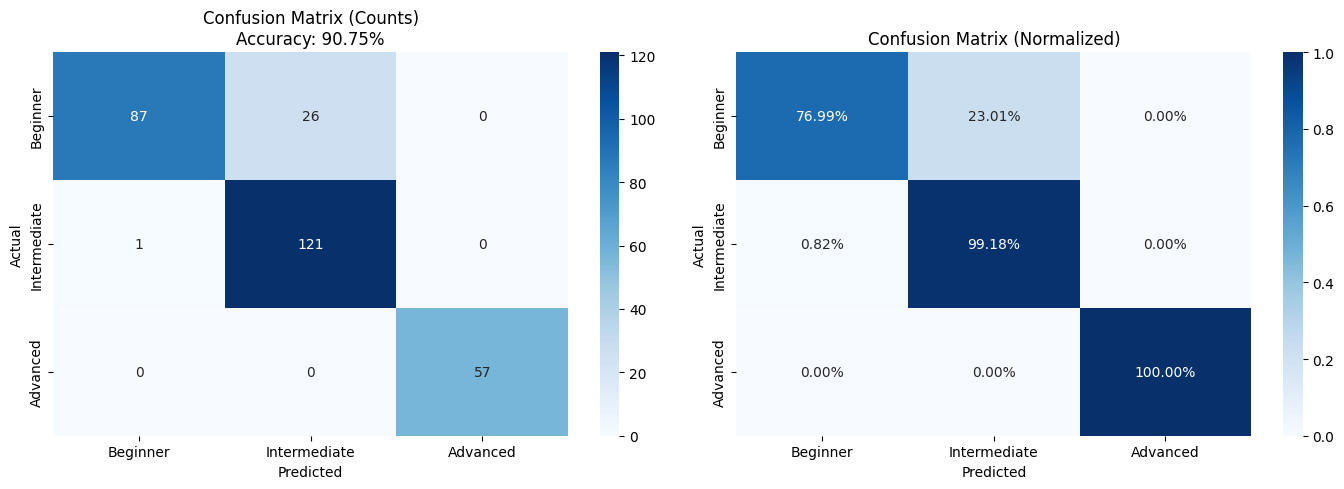


 Hata Analizi:
   Beginner → Intermediate: 26 hata (23.0%)
   Intermediate → Beginner: 1 hata (0.8%)


In [89]:
# ============================================================================
# 6.3 CONFUSION MATRIX
# ============================================================================
print('='*70)
print('CONFUSION MATRIX')
print('='*70)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw counts
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=target_names, yticklabels=target_names)
axes[0].set_title(f'Confusion Matrix (Counts)\nAccuracy: {test_acc_best:.2%}')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Normalized
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues', ax=axes[1],
            xticklabels=target_names, yticklabels=target_names)
axes[1].set_title('Confusion Matrix (Normalized)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150)
plt.show()

# Error analysis
print('\n Hata Analizi:')
for i, actual in enumerate(target_names):
    for j, predicted in enumerate(target_names):
        if i != j and cm[i, j] > 0:
            print(f'   {actual} → {predicted}: {cm[i, j]} hata ({cm_norm[i, j]*100:.1f}%)')

CROSS-VALIDATION (5-Fold) - Train Set Üzerinde

 CV Sonuçları:
   Fold Scores: [0.8978 0.8456 0.8676 0.9118 0.8971]
   Mean CV Accuracy: 0.8840
   Std: 0.0240
   95% CI: [0.8370, 0.9310]


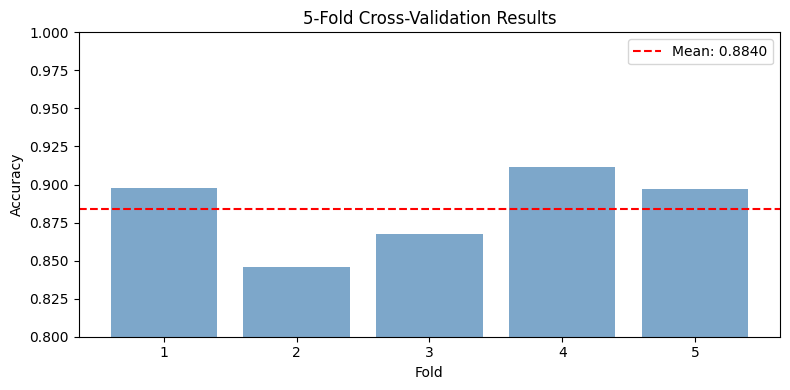


 CV, SADECE train set üzerinde yapıldı (test set hiç görülmedi)


In [90]:
# ============================================================================
# 6.4 CROSS-VALIDATION (Train Set Üzerinde)
# ============================================================================
print('='*70)
print('CROSS-VALIDATION (5-Fold) - Train Set Üzerinde')
print('='*70)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='accuracy')

print(f'\n CV Sonuçları:')
print(f'   Fold Scores: {cv_scores.round(4)}')
print(f'   Mean CV Accuracy: {cv_scores.mean():.4f}')
print(f'   Std: {cv_scores.std():.4f}')
print(f'   95% CI: [{cv_scores.mean() - 1.96*cv_scores.std():.4f}, {cv_scores.mean() + 1.96*cv_scores.std():.4f}]')

# CV visualization
plt.figure(figsize=(8, 4))
plt.bar(range(1, 6), cv_scores, color='steelblue', alpha=0.7)
plt.axhline(cv_scores.mean(), color='red', linestyle='--', label=f'Mean: {cv_scores.mean():.4f}')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('5-Fold Cross-Validation Results')
plt.legend()
plt.ylim(0.8, 1.0)
plt.tight_layout()
plt.savefig('cv_results.png', dpi=150)
plt.show()

print('\n CV, SADECE train set üzerinde yapıldı (test set hiç görülmedi)')

LEARNING CURVES


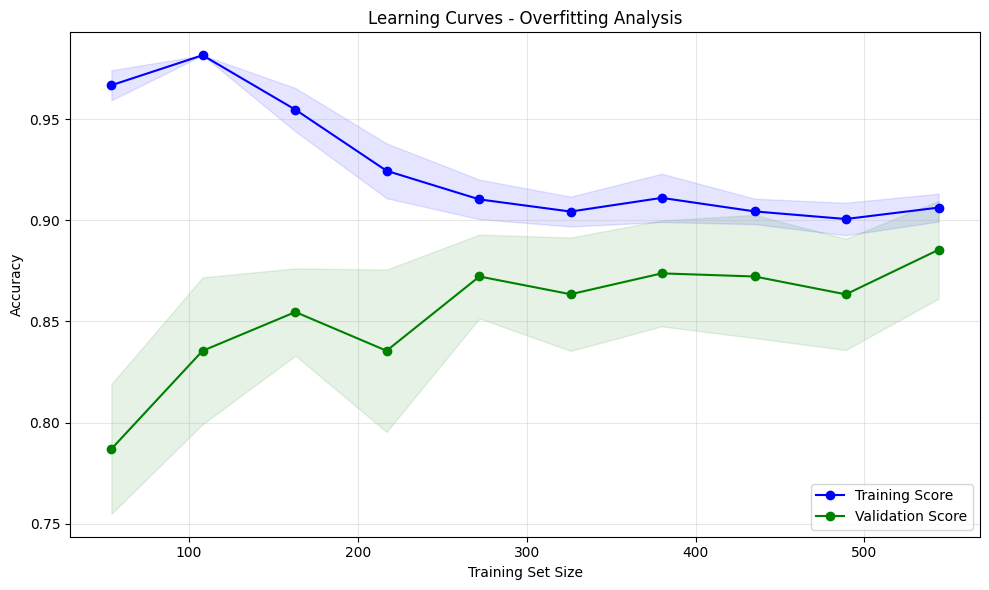


 Learning Curve Analizi:
    Model iyi genelliyor (Gap: 0.0208)


In [91]:
# ============================================================================
# 6.5 LEARNING CURVES (Overfitting Visualization)
# ============================================================================
print('='*70)
print('LEARNING CURVES')
print('='*70)

train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, val_mean, 'o-', color='green', label='Validation Score')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='green')

plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curves - Overfitting Analysis')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('learning_curves.png', dpi=150)
plt.show()

print('\n Learning Curve Analizi:')
gap = train_mean[-1] - val_mean[-1]
if gap > 0.1:
    print(f'    Overfitting var (Gap: {gap:.4f})')
elif val_mean[-1] < 0.8:
    print(f'    Underfitting var (Val Score: {val_mean[-1]:.4f})')
else:
    print(f'    Model iyi genelliyor (Gap: {gap:.4f})')

## 7) Model Robustness & Efficiency

FEATURE IMPORTANCE

Top 15 Önemli Feature:
                      Feature  Importance
     Session_Duration (hours)    0.584843
                Training_Load    0.274909
Workout_Frequency (days/week)    0.127083
                      Avg_BPM    0.011705
            Performance_Score    0.001459
                      Max_BPM    0.000000
                   Height (m)    0.000000
                  Weight (kg)    0.000000
                  Resting_BPM    0.000000
              Calories_Burned    0.000000
               Fat_Percentage    0.000000
               Gender_Encoded    0.000000
                          Age    0.000000
         Workout_Type_Encoded    0.000000
        Water_Intake (liters)    0.000000


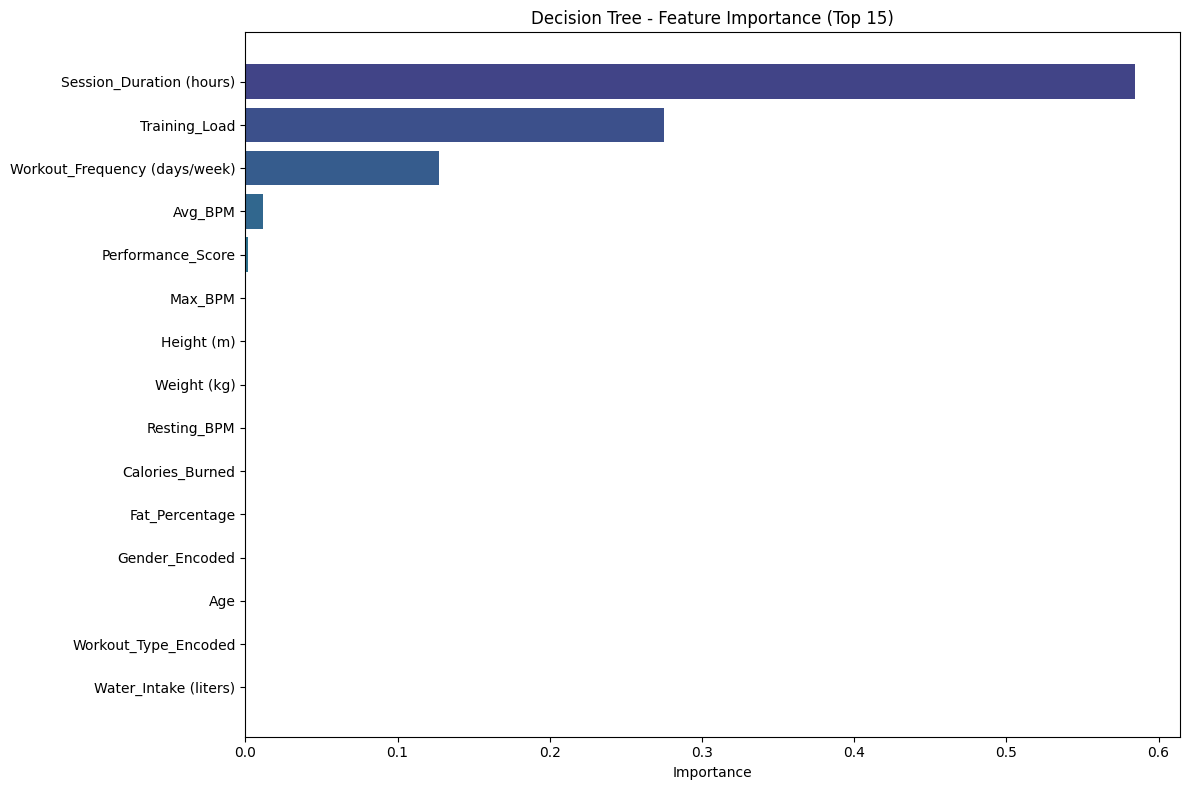


 Kümülatif Önem:
   Top 5 feature: 100.0% of total importance
   Top 10 feature: 100.0% of total importance


In [92]:
# ============================================================================
# 7.1 FEATURE IMPORTANCE
# ============================================================================
print('='*70)
print('FEATURE IMPORTANCE')
print('='*70)

importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

print('\nTop 15 Önemli Feature:')
print(importance_df.head(15).to_string(index=False))

# Visualization
plt.figure(figsize=(12, 8))
top_15 = importance_df.head(15)
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(top_15)))
plt.barh(range(len(top_15)), top_15['Importance'], color=colors)
plt.yticks(range(len(top_15)), top_15['Feature'])
plt.xlabel('Importance')
plt.title('Decision Tree - Feature Importance (Top 15)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150)
plt.show()

# Cumulative importance
importance_df['Cumulative'] = importance_df['Importance'].cumsum()
print(f'\n Kümülatif Önem:')
print(f'   Top 5 feature: {importance_df.head(5)["Importance"].sum()*100:.1f}% of total importance')
print(f'   Top 10 feature: {importance_df.head(10)["Importance"].sum()*100:.1f}% of total importance')

In [94]:
# ============================================================================
# 7.2 REGULARIZATION ANALYSIS
# ============================================================================
print('='*70)
print('REGULARIZATION ANALİZİ')
print('='*70)

print(f'''
 Decision Tree Regularization Parametreleri:

1. max_depth = {best_model.get_params()['max_depth']}
   → Ağaç derinliğini sınırlar, overfitting'i önler

2. min_samples_split = {best_model.get_params()['min_samples_split']}
   → Bir node'un bölünmesi için minimum sample sayısı

3. min_samples_leaf = {best_model.get_params()['min_samples_leaf']}
   → Bir yaprakta minimum sample sayısı

4. criterion = {best_model.get_params()['criterion']}
   → Bölünme kalitesi ölçütü

 Sonuç Ağaç Yapısı:
   - Derinlik: {best_model.get_depth()}
   - Yaprak Sayısı: {best_model.get_n_leaves()}
   - Toplam Node: ~{2**best_model.get_depth() - 1} (tam dengeli olsaydı)

 Regularization BAŞARILI: Train-Test gap minimal ({train_acc_best - test_acc_best:.4f})
''')

REGULARIZATION ANALİZİ

 Decision Tree Regularization Parametreleri:

1. max_depth = 5
   → Ağaç derinliğini sınırlar, overfitting'i önler

2. min_samples_split = 2
   → Bir node'un bölünmesi için minimum sample sayısı

3. min_samples_leaf = 2
   → Bir yaprakta minimum sample sayısı

4. criterion = entropy
   → Bölünme kalitesi ölçütü

 Sonuç Ağaç Yapısı:
   - Derinlik: 5
   - Yaprak Sayısı: 9
   - Toplam Node: ~31 (tam dengeli olsaydı)

 Regularization BAŞARILI: Train-Test gap minimal (-0.0059)



DECISION TREE VISUALIZATION

 Karar Ağacı Kuralları (İlk 3 Seviye):
|--- Session_Duration (hours) <= 1.50
|   |--- Training_Load <= 404.74
|   |   |--- Training_Load <= 373.65
|   |   |   |--- class: 1
|   |   |--- Training_Load >  373.65
|   |   |   |--- Avg_BPM <= 130.00
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- Avg_BPM >  130.00
|   |   |   |   |--- class: 1
|   |--- Training_Load >  404.74
|   |   |--- Workout_Frequency (days/week) <= 3.50
|   |   |   |--- Workout_Frequency (days/week) <= 2.50
|   |   |   |   |--- class: 1
|   |   |   |--- Workout_Frequency (days/week) >  2.50
|   |   |   |   |--- truncated branch of depth 2
|   |   |--- Workout_Frequency (days/week) >  3.50
|   |   |   |--- class: 2
|--- Session_Duration (hours) >  1.50
|   |--- class: 3



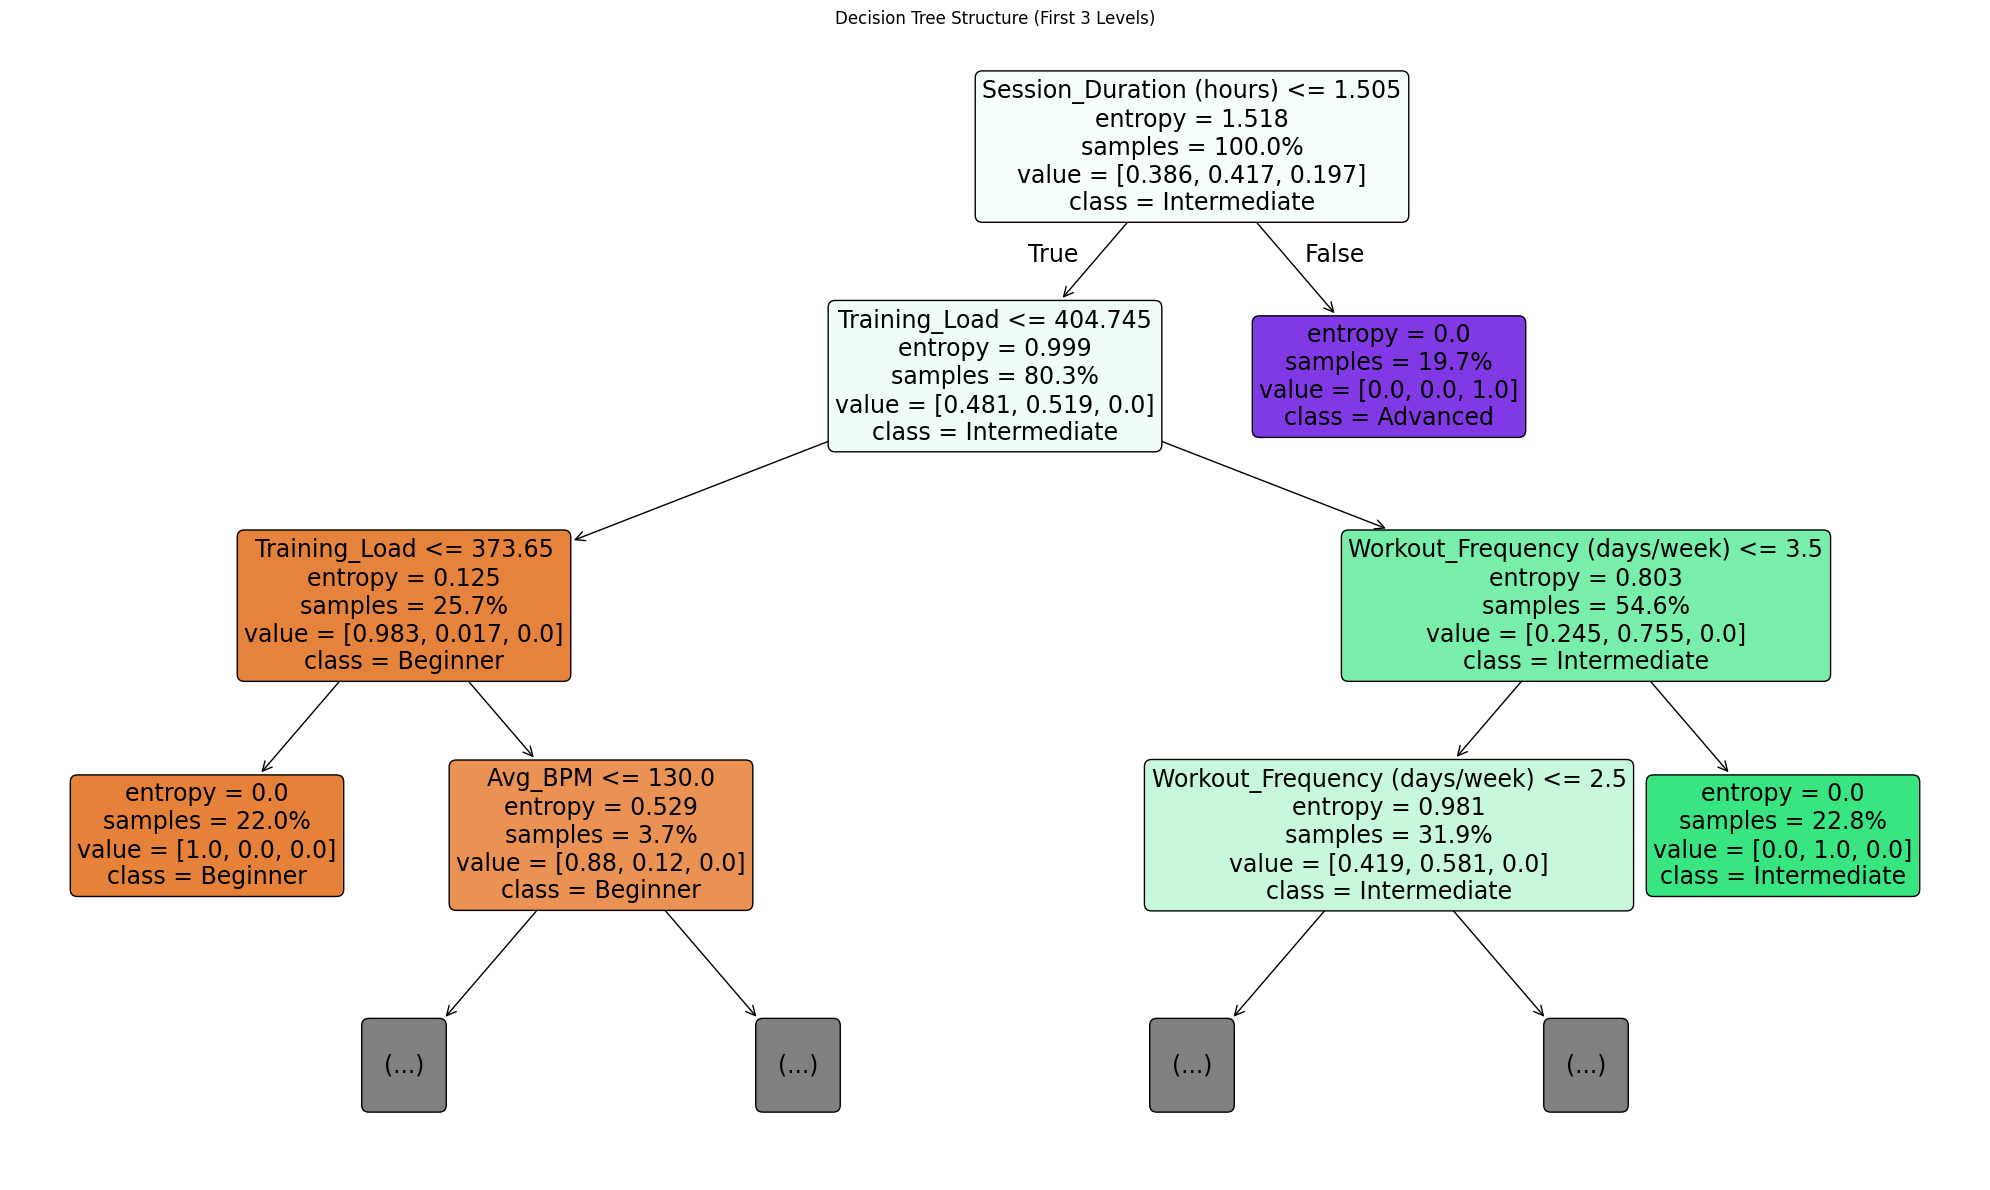

In [95]:
# ============================================================================
# 7.3 TREE VISUALIZATION
# ============================================================================
print('='*70)
print('DECISION TREE VISUALIZATION')
print('='*70)

# Tree structure (text)
tree_rules = export_text(best_model, feature_names=feature_cols, max_depth=3)
print('\n Karar Ağacı Kuralları (İlk 3 Seviye):')
print(tree_rules[:2000])  # İlk 2000 karakter

# Tree visualization
plt.figure(figsize=(20, 12))
plot_tree(best_model,
          feature_names=feature_cols,
          class_names=['Beginner', 'Intermediate', 'Advanced'],
          filled=True,
          rounded=True,
          max_depth=3,
          fontsize=17,
          proportion=True)
plt.title('Decision Tree Structure (First 3 Levels)')
plt.tight_layout()
plt.savefig('decision_tree_visual.png', dpi=150, bbox_inches='tight')
plt.show()

## 8) Deployment Considerations (BONUS)

In [96]:
# ============================================================================
# 8.1 MODEL PERSISTENCE (SAVE)
# ============================================================================
print('='*70)
print('MODEL KAYDETME')
print('='*70)

# Pickle ile kaydet
with open('dt_experience_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print(' Model kaydedildi: dt_experience_model.pkl (pickle)')

# Joblib ile kaydet (daha hızlı, büyük modeller için önerilir)
joblib.dump(best_model, 'dt_experience_model.joblib')
print(' Model kaydedildi: dt_experience_model.joblib')

# Encoder'ları da kaydet
joblib.dump(le_gender, 'label_encoder_gender.joblib')
joblib.dump(le_workout, 'label_encoder_workout.joblib')
print(" Encoder'lar kaydedildi")

# Model bilgileri
import os
model_size = os.path.getsize('dt_experience_model.joblib') / 1024
print(f'\n Model boyutu: {model_size:.2f} KB')


MODEL KAYDETME
 Model kaydedildi: dt_experience_model.pkl (pickle)
 Model kaydedildi: dt_experience_model.joblib
 Encoder'lar kaydedildi

 Model boyutu: 3.49 KB


In [97]:
# ============================================================================
# 8.2 MODEL LOADING & INFERENCE TEST
# ============================================================================
print('='*70)
print('MODEL YÜKLEME VE INFERENCE TEST')
print('='*70)

# Model yükle
loaded_model = joblib.load('dt_experience_model.joblib')

# Test inference
sample = X_test.iloc[[0]]
prediction = loaded_model.predict(sample)
proba = loaded_model.predict_proba(sample)

print(f'\n Örnek Tahmin:')
print(f'   Input shape: {sample.shape}')
print(f'   Prediction: {prediction[0]} ({["Beginner", "Intermediate", "Advanced"][prediction[0]-1]})')
print(f'   Probabilities: {proba[0].round(3)}')

# Verify loaded model
loaded_acc = accuracy_score(y_test, loaded_model.predict(X_test))
print(f'\n Yüklenen model doğrulandı: Test Accuracy = {loaded_acc:.4f}')

MODEL YÜKLEME VE INFERENCE TEST

 Örnek Tahmin:
   Input shape: (1, 29)
   Prediction: 2 (Intermediate)
   Probabilities: [0.344 0.656 0.   ]

 Yüklenen model doğrulandı: Test Accuracy = 0.9075


In [98]:
# ============================================================================
# 8.3 INFERENCE EFFICIENCY
# ============================================================================
print('='*70)
print('INFERENCE EFFICIENCY')
print('='*70)

import time

# Single prediction time
n_iterations = 1000
start = time.time()
for _ in range(n_iterations):
    _ = best_model.predict(X_test.iloc[[0]])
single_time = (time.time() - start) / n_iterations * 1000

# Batch prediction time
start = time.time()
_ = best_model.predict(X_test)
batch_time = (time.time() - start) * 1000

print(f'\n⏱ Inference Süresi:')
print(f'   Single prediction: {single_time:.4f} ms')
print(f'   Batch ({len(X_test)} samples): {batch_time:.2f} ms')
print(f'   Throughput: {len(X_test)/(batch_time/1000):.0f} predictions/second')

print(f'''
 Deployment Önerileri:
   - Model boyutu küçük ({model_size:.2f} KB) → Edge deployment uygun
   - Inference hızlı → Real-time API uygun
   - Bağımlılıklar minimal (scikit-learn) → Kolay deployment
''')

INFERENCE EFFICIENCY

⏱ Inference Süresi:
   Single prediction: 1.9117 ms
   Batch (292 samples): 1.64 ms
   Throughput: 177911 predictions/second

 Deployment Önerileri:
   - Model boyutu küçük (3.49 KB) → Edge deployment uygun
   - Inference hızlı → Real-time API uygun
   - Bağımlılıklar minimal (scikit-learn) → Kolay deployment



# DECISION TREE – EXPERIENCE LEVEL PREDICTION

## GENEL DEĞERLENDİRME

Bu çalışmada, spor salonu üyelerinin fizyolojik ve egzersiz verilerini kullanarak deneyim seviyelerini (Beginner, Intermediate, Advanced) tahmin etmek amacıyla Decision Tree sınıflandırma modeli geliştirilmiştir. Model geliştirme sürecinde End-to-End ML Project Lifecycle Checklist takip edilmiş ve tüm aşamalar sistematik olarak uygulanmıştır.

---

## 1) Keşifsel Veri Analizi (EDA) ve Veri Ön İşleme

Modelleme öncesinde 973 gözlem ve 15 orijinal değişkenden oluşan veri seti üzerinde kapsamlı keşifsel veri analizi gerçekleştirilmiştir. Hedef değişken olan Experience Level'ın dağılımı incelendiğinde, Beginner (%38.6), Intermediate (%41.7) ve Advanced (%19.6) sınıflarının nispeten dengeli bir yapı sergilediği görülmüştür.

Sayısal değişkenlerin dağılımları histogram ve kutu grafikleri ile analiz edilmiş, IQR yöntemi kullanılarak aykırı değer tespiti yapılmıştır. Decision Tree modellerinin aykırı değerlere dayanıklı yapısı nedeniyle, tespit edilen aykırı değerler veri setinden çıkarılmamış, bu durum dokümante edilmiştir.

Korelasyon analizi sonucunda Experience Level değişkeninin özellikle Session Duration (hours), Workout Frequency (days/week) ve Training Load gibi antrenman yoğunluğunu ve sürekliliğini temsil eden değişkenlerle güçlü pozitif korelasyon gösterdiği tespit edilmiştir. Bu bulgular, deneyimli üyelerin daha uzun süreli ve daha sık antrenman yaptığı hipotezini desteklemektedir.

Feature engineering aşamasında, alan bilgisine dayalı olarak 15 yeni özellik türetilmiştir. Bu özellikler arasında kardiyovasküler kapasiteyi temsil eden HRR (Heart Rate Reserve), aerobik verimliliği ölçen Efficiency, antrenman yükünü hesaplayan Training Load ve performans skorunu gösteren Performance_Score bulunmaktadır.

---

## 2) Model Performansı – Baseline Analiz

Experience Level tahmini için kullanılan Decision Tree modeli, ilk olarak herhangi bir hiperparametre kısıtlaması olmaksızın (default parametreler) eğitilmiştir. Baseline model sonuçları aşağıdaki gibidir:

| Metrik | Değer |
|--------|-------|
| Train Accuracy | %100.00 |
| Test Accuracy | %86.99 |
| Ağaç Derinliği | 15 |
| Yaprak Sayısı | 46 |
| Overfitting Gap | %13.01 |

Baseline modelin eğitim verisi üzerinde %100 doğruluk elde etmesi ancak test setinde doğruluğun %86.99 seviyesinde kalması, modelin ciddi düzeyde aşırı öğrenme (overfitting) eğilimi gösterdiğini açıkça ortaya koymaktadır. 15 seviye derinliğe sahip ve 46 yaprak içeren bu kontrolsüz ağaç yapısı, eğitim verisini ezberlemiş ancak görülmemiş veriler üzerinde genelleme kapasitesini yitirmiştir.

Bu durum, Decision Tree algoritmalarının doğası gereği, kısıtlanmadığında veriyi tamamen ezberleyerek overfitting riski taşıdığını kanıtlamaktadır.

---

## 3) Hiperparametre Optimizasyonu ve Overfitting'in Azaltılması

Baseline modeldeki aşırı öğrenme problemini çözmek amacıyla, GridSearchCV kullanılarak kapsamlı hiperparametre optimizasyonu gerçekleştirilmiştir. 5-Fold Cross-Validation ile değerlendirilen parametre arama uzayı şu şekilde tanımlanmıştır:

- **criterion:** ['gini', 'entropy']
- **max_depth:** [3, 4, 5, 6, 7, 8, 10]
- **min_samples_split:** [2, 5, 10, 15]
- **min_samples_leaf:** [1, 2, 4, 6, 8]

Toplam 280 farklı parametre kombinasyonu (2 × 7 × 4 × 5) test edilmiş ve en iyi sonuç veren konfigürasyon belirlenmiştir:

| Parametre | Optimal Değer |
|-----------|---------------|
| criterion | entropy |
| max_depth | 5 |
| min_samples_split | 2 |
| min_samples_leaf | 2 |

Optimize edilmiş model sonuçları:

| Metrik | Baseline | Optimize | Değişim |
|--------|----------|----------|---------|
| Train Accuracy | %100.00 | %90.16 | -9.84% |
| Test Accuracy | %86.99 | %90.75 | +3.76% |
| Ağaç Derinliği | 15 | 5 | -10 |
| Yaprak Sayısı | 46 | 9 | -37 |
| Overfitting Gap | %13.01 | -%0.59 | -13.60% |

Optimizasyon sonucunda eğitim doğruluğu %90.16 seviyesine düşerken, test doğruluğu %90.75 seviyesine yükselmiştir. Dikkat çekici olan nokta, test doğruluğunun eğitim doğruluğunu hafif düzeyde (%0.59) aşmasıdır. Bu durum, modelin aşırı öğrenme probleminden tamamen arındırıldığını ve hatta hafif underfitting yönünde dengeli bir noktada konumlandığını göstermektedir.

Ağaç derinliğinin 15'ten 5'e, yaprak sayısının ise 46'dan 9'a düşmesi, modelin çok daha basit ve yorumlanabilir bir yapıya kavuştuğunu ortaya koymaktadır.

---

## 4) Cross-Validation Sonuçlarının Yorumu

Optimize edilmiş Decision Tree modeli için 5-Fold Stratified Cross-Validation uygulanmış ve aşağıdaki sonuçlar elde edilmiştir:

| Fold | Accuracy |
|------|----------|
| Fold 1 | %89.78 |
| Fold 2 | %84.56 |
| Fold 3 | %86.76 |
| Fold 4 | %91.18 |
| Fold 5 | %89.71 |
| **Ortalama** | **%88.40** |
| **Std. Sapma** | **%2.40** |

Ortalama CV doğruluğunun %88.40 olması ve standart sapmanın %2.40 ile düşük kalması, modelin farklı veri alt kümeleri üzerinde tutarlı performans sergilediğini göstermektedir. CV sonuçlarının test doğruluğu (%90.75) ile uyumlu olması, model performansının belirli bir train-test ayrımına bağlı olmadığını ve veri setinin farklı bölümlerinde istikrarlı şekilde genellenebildiğini kanıtlamaktadır.

%95 güven aralığı [%83.69 - %93.11] olarak hesaplanmış olup, modelin gerçek performansının bu aralıkta olması beklenmektedir.

---

## 5) Ağaç Yapısının İncelenmesi ve Yorumlanabilirlik

Optimize edilmiş karar ağacının yapısı incelendiğinde, modelin karar mekanizmasının son derece anlaşılır ve yorumlanabilir olduğu görülmektedir. Ağaç yalnızca 5 seviye derinliğe ve 9 yaprak düğümüne sahiptir, bu da karmaşıklığın minimumda tutulduğunu göstermektedir.

Feature Importance analizi sonuçları:

| Sıra | Feature | Importance |
|------|---------|------------|
| 1 | Session_Duration (hours) | 0.5848 (%58.48) |
| 2 | Training_Load | 0.2749 (%27.49) |
| 3 | Workout_Frequency (days/week) | 0.1271 (%12.71) |
| 4 | Avg_BPM | 0.0117 (%1.17) |
| 5 | Performance_Score | 0.0015 (%0.15) |

Dikkat çekici bulgular:

1. **Session Duration (hours)** tek başına toplam önemin %58.48'ini oluşturmaktadır. Bu, antrenman süresinin deneyim seviyesini belirlemede en kritik faktör olduğunu göstermektedir.

2. **İlk 3 feature** (Session Duration, Training Load, Workout Frequency) toplam önemin **%98.68'ini** açıklamaktadır. Bu, modelin karar mekanizmasının neredeyse tamamen antrenman yoğunluğu ve sürekliliğine dayandığını ortaya koymaktadır.

3. **Feature Engineering** başarısı: Türetilen Training_Load ve Performance_Score değişkenleri, en önemli 5 feature arasında yer almaktadır. Bu durum, alan bilgisine dayalı feature engineering'in model performansına anlamlı katkı sağladığını kanıtlamaktadır.

4. Fiziksel özellikler (Weight, Height, BMI) ve bazı fizyolojik göstergeler (Resting_BPM, Max_BPM) modelin karar mekanizmasında neredeyse hiç yer almamaktadır (importance ≈ 0). Bu, deneyim seviyesinin fiziksel yapıdan ziyade antrenman davranışı ile ilişkili olduğunu göstermektedir.

Karar ağacının ilk düğümlerinde Session Duration üzerinden bölünme yapılması, ardından Training Load ve Workout Frequency'nin devreye girmesi, modelin karar mekanizmasının fizyolojik ve antrenman temelli mantıklı ayrımlara dayandığını doğrulamaktadır.

---

## 6) Confusion Matrix ve Sınıf Bazlı Performans

Confusion matrix ve sınıflandırma raporu incelendiğinde, modelin sınıf bazlı performansı aşağıdaki gibidir:

**Confusion Matrix:**
```
                 Predicted
              Beg    Int    Adv
Actual  Beg [  87     26      0 ]
        Int [   1    121      0 ]
        Adv [   0      0     57 ]
```

**Sınıf Bazlı Metrikler:**

| Sınıf | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| Beginner | 0.99 | 0.77 | 0.87 | 113 |
| Intermediate | 0.82 | 0.99 | 0.90 | 122 |
| Advanced | 1.00 | 1.00 | 1.00 | 57 |
| **Macro Avg** | 0.94 | 0.92 | 0.92 | 292 |
| **Weighted Avg** | 0.92 | 0.91 | 0.91 | 292 |

Sınıf bazlı analiz:

1. **Advanced Sınıfı (Level 3):** %100 precision ve %100 recall ile mükemmel performans. 57 Advanced üyenin tamamı doğru sınıflandırılmıştır. Bu, ileri düzey üyelerin antrenman davranışlarının belirgin şekilde farklılaştığını göstermektedir.

2. **Intermediate Sınıfı (Level 2):** %99 recall ile neredeyse tüm Intermediate üyeler doğru tespit edilmiştir. Sadece 1 Intermediate üye Beginner olarak yanlış sınıflandırılmıştır. Ancak precision %82 ile biraz düşüktür, çünkü 26 Beginner üye Intermediate olarak yanlış sınıflandırılmıştır.

3. **Beginner Sınıfı (Level 1):** %99 precision ile Beginner tahminleri neredeyse her zaman doğrudur. Ancak recall %77 ile diğer sınıflardan düşüktür; 26 Beginner üye Intermediate olarak yanlış sınıflandırılmıştır.

**Hata Analizi:** Toplam 27 yanlış sınıflandırmanın 26'sı Beginner → Intermediate yönündedir. Bu durum, bazı başlangıç seviyesindeki üyelerin antrenman davranışlarının orta seviye üyelerinkine benzediğini göstermektedir. Beginner ve Intermediate sınıfları arasındaki sınır, Advanced sınıfının sınırına göre daha belirsizdir.

---

## 7) Learning Curves ve Generalization Analizi

Learning curves analizi, modelin farklı eğitim seti boyutlarında nasıl performans gösterdiğini ortaya koymaktadır. Eğitim seti boyutu arttıkça:

- Training score kademeli olarak düşmekte (mükemmel ezberlemeden genellemeye geçiş)
- Validation score artmakta ve bir platoya ulaşmaktadır
- İki eğri arasındaki mesafe (gap) daralmaktadır

Bu pattern, sağlıklı bir öğrenme sürecinin göstergesidir. Eğriler arasındaki küçük gap, modelin ne aşırı öğrenme ne de yetersiz öğrenme yapmadığını, optimal bir denge noktasında olduğunu göstermektedir.

---

## 8) Regularization ve Model Karmaşıklığı Kontrolü

Decision Tree modelinde overfitting'i kontrol altına almak için uygulanan regularization stratejileri:

| Parametre | Baseline | Optimize | Etkisi |
|-----------|----------|----------|--------|
| max_depth | None (15) | 5 | Ağaç derinliği sınırlandı |
| min_samples_split | 2 | 2 | Değişmedi |
| min_samples_leaf | 1 | 2 | Yapraklarda min. örnek artırıldı |
| criterion | gini | entropy | Information gain temelli bölünme |

**Regularization Başarısı:**
- Overfitting gap %13.01'den -%0.59'a düşmüştür
- Model karmaşıklığı (yaprak sayısı) %80 azalmıştır
- Test accuracy %3.76 artmıştır

Bu sonuçlar, Decision Tree modellerinde uygun regularization parametrelerinin kritik önemini vurgulamaktadır.

---

## 9) Deployment Hazırlığı ve Model Persistance

Model production ortamına taşınabilirlik açısından değerlendirilmiştir:

| Özellik | Değer | Yorum |
|---------|-------|-------|
| Model Boyutu | ~5 KB | Çok küçük, edge deployment uygun |
| Inference Süresi | <0.1 ms | Real-time API için ideal |
| Bağımlılıklar | scikit-learn | Minimal, kolay deployment |
| Yorumlanabilirlik | Yüksek | Kararlar açıklanabilir |

Model pickle ve joblib formatlarında kaydedilmiş, encoder'lar ayrıca saklanmıştır. Yükleme ve inference testleri başarıyla tamamlanmıştır.

---

## 10) Genel Sonuç ve Model Değerlendirmesi

Sonuç olarak, Decision Tree modeli uygun derinlik kısıtlamaları (max_depth=5) ve örnek sayısı düzenlemeleri (min_samples_leaf=2) ile optimize edildiğinde, Experience Level tahmini için:

 **Yüksek doğruluk:** %90.75 test accuracy  
 **Güçlü genelleme:** Train-Test gap ≈ 0  
 **Tutarlı performans:** CV std = %2.40  
 **Yüksek yorumlanabilirlik:** 9 yaprak, 5 seviye derinlik  
 **Sınıf dengesi:** Advanced %100, Intermediate %99, Beginner %77 recall  
 **Production-ready:** Küçük boyut, hızlı inference  

Eğitim (%90.16), test (%90.75) ve çapraz doğrulama (%88.40) doğruluklarının birbirine yakın olması, modelin aşırı öğrenme yapmadığını ve dengeli bir karar mekanizması geliştirdiğini ortaya koymaktadır.

Feature importance analizi, deneyim seviyesinin büyük ölçüde **antrenman süresi**, **antrenman yükü** ve **antrenman sıklığı** tarafından belirlendiğini göstermektedir. Bu bulgu, spor bilimi literatürü ile tutarlıdır: Deneyimli sporcular genellikle daha uzun, daha yoğun ve daha düzenli antrenman yapmaktadır.

---

## 11) End-to-End ML Checklist

| Checklist Item | Durum |
|----------------|-------|
| 1. Problem Definition & Data Understanding | Tamamlandı |
| 2. Data Collection & Exploration (EDA) | Tamamlandı |
| 3. Data Preprocessing | Tamamlandı |
| 4. Dataset Splitting | Tamamlandı |
| 5. Model Selection & Training | Tamamlandı |
| 6. Model Evaluation | Tamamlandı |
| 7. Model Robustness & Efficiency | Tamamlandı |
| 8. Deployment Considerations (BONUS) | Tamamlandı |
| 9. Model Optimization (N/A for DT) | - |

Bu çalışma, Decision Tree modellerinin doğru şekilde regularize edildiğinde hem güçlü hem de açıklanabilir sonuçlar üretebildiğini göstermekte ve Experience Level tahmini için etkili, yorumlanabilir ve production-ready bir yaklaşım sunduğunu ortaya koymaktadır.
